In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
aapl = pd.read_csv('aapl.us.txt', index_col='Date')
mask = (aapl.index > '2007-11-10') & (aapl.index <= '2017-11-10')
aapl = aapl.loc[mask]

amzn = pd.read_csv('amzn.us.txt', index_col='Date')
mask = (amzn.index > '2007-11-10') & (amzn.index <= '2017-11-10')
amzn = amzn.loc[mask]

csco = pd.read_csv('csco.us.txt', index_col='Date')
mask = (csco.index > '2007-11-10') & (csco.index <= '2017-11-10')
csco = csco.loc[mask]

ibm = pd.read_csv('ibm.us.txt', index_col='Date')
mask = (ibm.index > '2007-11-10') & (ibm.index <= '2017-11-10')
ibm = ibm.loc[mask]

In [3]:
stocks = pd.concat([aapl['Close'],amzn['Close'],csco['Close'],ibm['Close']], axis=1)
stocks.columns = ['Apple', 'Amazon', 'Cisco', 'IBM']
stocks.head()

,Apple,Amazon,Cisco,IBM
Date,,,,
2007-11-12,19.691,77.00,24.052,84.712
2007-11-13,21.765,79.86,24.901,87.907
2007-11-14,21.274,78.51,24.547,86.375
2007-11-15,21.040,77.85,24.207,86.506
2007-11-16,21.309,78.60,24.737,87.500


In [4]:
stocks.pct_change(1).mean() # mean daily return

Apple     0.001064
Amazon    0.001359
Cisco     0.000310
IBM       0.000323
dtype: float64

In [5]:
stocks.pct_change(1).corr()

,Apple,Amazon,Cisco,IBM
Apple,1.000000,0.450366,0.492256,0.464932
Amazon,0.450366,1.000000,0.447742,0.412995
Cisco,0.492256,0.447742,1.000000,0.564384
IBM,0.464932,0.412995,0.564384,1.000000


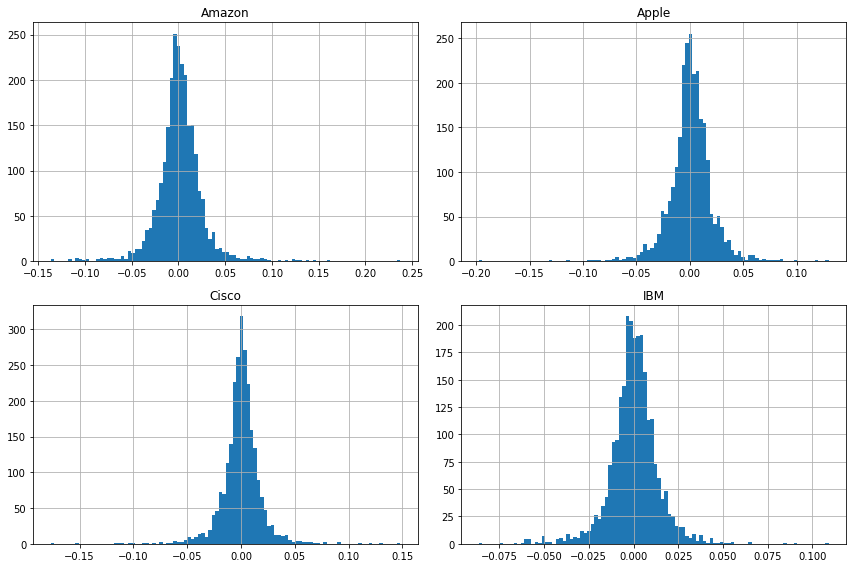

In [6]:
log_returns = np.log(stocks/stocks.shift(1))
log_returns.hist(bins=100, figsize=(12,8))
plt.tight_layout()

In [7]:
log_returns.mean()

Apple     0.000867
Amazon    0.001065
Cisco     0.000137
IBM       0.000225
dtype: float64

In [8]:
log_returns.cov() * 252

,Apple,Amazon,Cisco,IBM
Apple,0.099275,0.055036,0.045633,0.032501
Amazon,0.055036,0.147088,0.051144,0.035590
Cisco,0.045633,0.051144,0.087483,0.037006
IBM,0.032501,0.035590,0.037006,0.049556


# Random allocation

In [9]:
# Initialization of weights
np.random.seed(101)
print(stocks.columns)
weights = np.array(np.random.random(4))

print('Random weights')
print(weights)

print('Rebalance')
weights = weights/np.sum(weights)
print(weights)
print('==='*20)

# Expected returns
print('Expected Portfolio Return')
exp_return = np.sum((log_returns.mean() * weights * 252)) 
print(exp_return)
print('==='*20)

# Expected volatility
print('Expected Portfolio Volatility')
exp_volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252, weights))) 
print(exp_volatility)
print('==='*20)

# Sharpe Ration
print('Sharpe Ration')
SR = exp_return/exp_volatility
print(SR)

Index(['Apple', 'Amazon', 'Cisco', 'IBM'], dtype='object')
Random weights
[0.51639863 0.57066759 0.02847423 0.17152166]
Rebalance
[0.40122278 0.44338777 0.02212343 0.13326603]
Expected Portfolio Return
0.2149703550284961
Expected Portfolio Volatility
0.27407193983766126
Sharpe Ration
0.7843574032271515


In [10]:
number_of_ports = 10000
all_weights = np.zeros((number_of_ports, len(stocks.columns)))
returns_array = np.zeros(number_of_ports)
volatility_array = np.zeros(number_of_ports)
sharpe_array = np.zeros(number_of_ports)

for i in range(number_of_ports):
    # Create Random Weights
    weights = np.array(np.random.random(4))
    # Rebalance Weights
    weights = weights/np.sum(weights)
    # Saving the weights
    all_weights[i,:] = weights

    # Expected returns
    returns_array[i] = np.sum((log_returns.mean() * weights * 252)) 
   
    # Expected volatility
    volatility_array[i] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252, weights))) 
    
    # Sharpe Ration
    sharpe_array[i] = returns_array[i]/volatility_array[i]


In [11]:
print(sharpe_array.max())
print(sharpe_array.argmax())
print(all_weights[1049, :])

0.8154331722070741
1049
[0.40726462 0.41194216 0.14481525 0.03597797]


In [23]:
max_sr_return = returns_array[1049]
max_sr_volatility = volatility_array[1049]

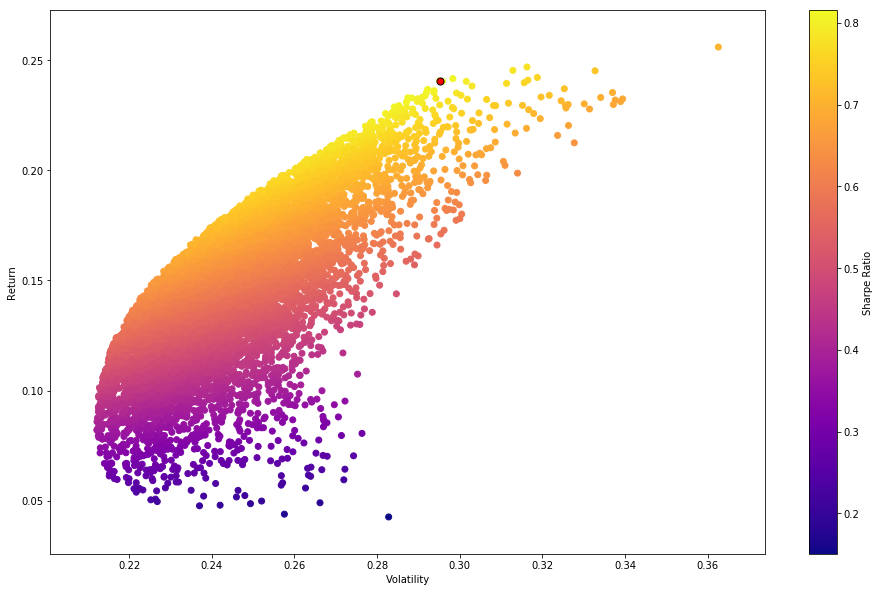

In [24]:
plt.figure(figsize=(16,10))
plt.scatter(volatility_array, returns_array, c=sharpe_array, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.scatter(max_sr_volatility, max_sr_return, c='r', s=50, edgecolors='black')

In [25]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [29]:
from scipy.optimize import minimize

In [30]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [31]:
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [32]:
cons = ({'type':'eq','fun': check_sum})
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))
init_guess = [0.25,0.25,0.25,0.25]
optimal_res = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

NameError: name 'log_ret' is not defined

In [17]:
optimal_res

     fun: -0.7391817010834291
     jac: array([0.6323837 , 0.74153681, 0.65244533, 0.36959084])
 message: 'Optimization terminated successfully.'
    nfev: 24
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0., 0., 0., 1.])

In [18]:
get_ret_vor_sr(optimal_res.x)

array([0.14076553, 0.19043428, 0.7391817 ])

# Efficient Frontier

In [19]:
frontier_y = np.linspace(0,0.3,100)

In [20]:
def minimize_volatility(weights):
    return  get_ret_vor_sr(weights)[1] 

In [21]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vor_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

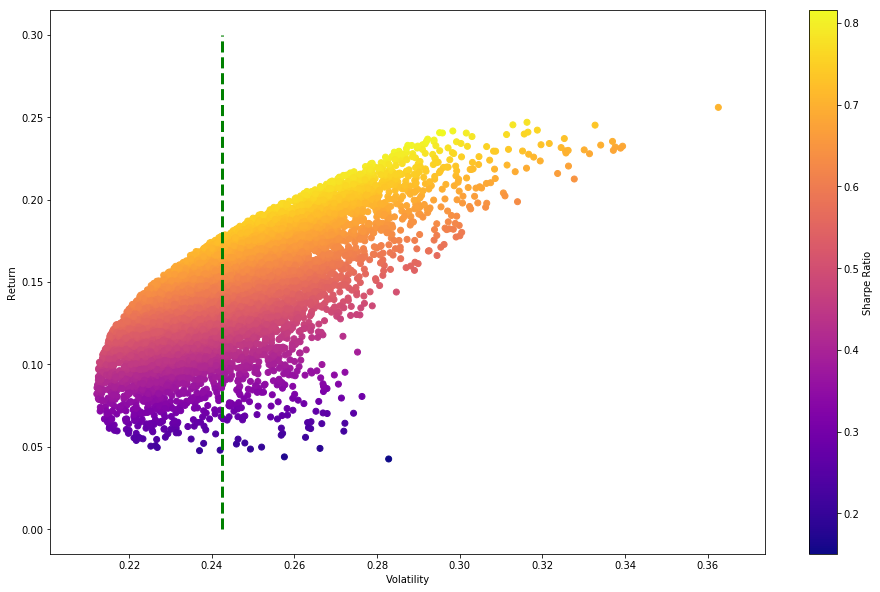

In [22]:
plt.figure(figsize=(16,10))
plt.scatter(volatility_array, returns_array, c=sharpe_array, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3)